# Customer Segmentation – Mall Customers

**Team:** Group 5  
**Topic:** Customer Segmentation (Unsupervised Learning)  
**Dataset:** Mall_Customers.csv  
(Contains: CustomerID, Gender, Age, Annual Income (k$), Spending Score (1-100))

In [3]:
import os, joblib, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    pairwise_distances_argmin
)
from sklearn.decomposition import PCA

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

FIGDIR = Path("figs"); FIGDIR.mkdir(exist_ok=True)


## Project Proposal
**Problem:** Treating all customers the same wastes budget and lowers ROI. We need natural groups to target promos, bundles, and pricing more effectively.

**Objectives**
- Discover **3–8** meaningful segments with **unsupervised** learning  
- Create **clear profiles** (age, income, spending; gender mix)  
- Provide a **simple API** that assigns a new customer to a segment

**Scope & Approach**
- Dataset: *Mall Customers*  
- Steps: Clean → EDA → Try KMeans/GMM/Agglomerative → Pick best via internal indices (Silhouette ↑, CH ↑, DB ↓) → Tune → Validate on a hold-out split → Save pipeline + Flask API → Present figures & business insights.


In [4]:
# Upload Mall_Customers.csv
DATA_PATH = "Mall_Customers.csv"
if not Path(DATA_PATH).exists():
    try:
        from google.colab import files
        print("Upload Mall_Customers.csv …")
        uploaded = files.upload()
        DATA_PATH = list(uploaded.keys())[0]
    except Exception as e:
        raise FileNotFoundError("Mall_Customers.csv not found. Upload it.")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
print("\nMissing values per column:\n", df.isna().sum())

# Basic cleaning
df = df.drop_duplicates().reset_index(drop=True)

# Rename for convenience
df = df.rename(columns={
    "Annual Income (k$)": "AnnualIncome",
    "Spending Score (1-100)": "SpendingScore"
})

# Keep modeling columns
use_cols = ["Gender", "Age", "AnnualIncome", "SpendingScore"]
X_raw = df[use_cols].copy()

# Preprocess: impute → encode (Gender) → scale (numeric)
num_cols = ["Age", "AnnualIncome", "SpendingScore"]
cat_cols = ["Gender"]

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
], remainder="drop")

# Split for stability validation later
X_train_raw, X_test_raw = train_test_split(
    X_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=None
)

X_train = preprocessor.fit_transform(X_train_raw)
X_test  = preprocessor.transform(X_test_raw)

print("Processed shapes → train:", X_train.shape, " test:", X_test.shape)


Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



Missing values per column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Processed shapes → train: (160, 5)  test: (40, 5)


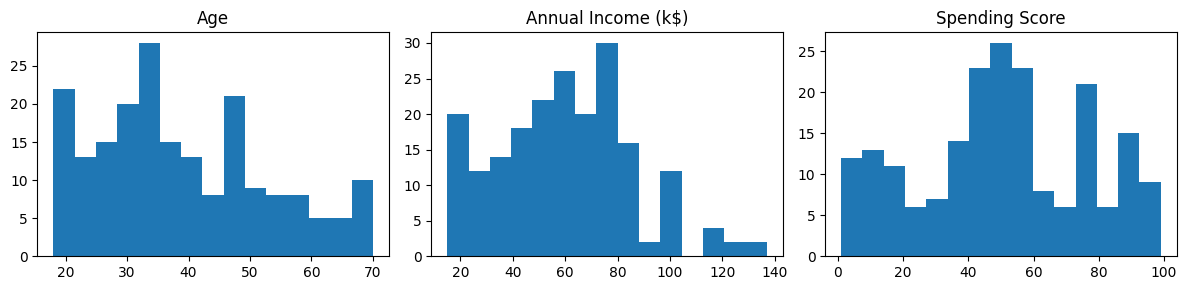

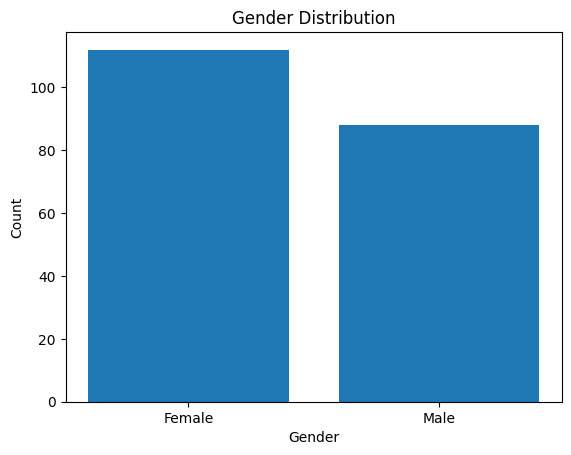

In [5]:
# Histograms
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].hist(df["Age"], bins=15); axes[0].set_title("Age")
axes[1].hist(df["AnnualIncome"], bins=15); axes[1].set_title("Annual Income (k$)")
axes[2].hist(df["SpendingScore"], bins=15); axes[2].set_title("Spending Score")
plt.tight_layout(); plt.savefig(FIGDIR/"eda_hist.png", bbox_inches="tight"); plt.show()

# Gender counts
counts = df["Gender"].value_counts()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Gender Distribution"); plt.xlabel("Gender"); plt.ylabel("Count")
plt.savefig(FIGDIR/"eda_gender.png", bbox_inches="tight"); plt.show()


## Model Building
- Tried different clustering algorithms:
  - **KMeans**  
  - **Gaussian Mixture Model (GMM)**  
  - **Agglomerative Hierarchical Clustering**
- Tested different numbers of clusters (k = 3 to 8).
- Evaluated each with internal metrics such as Silhouette score.




c:\Users\priyesh bhalala\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\priyesh bhalala\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\priyesh bhalala\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\priyesh bha

,silhouette,calinski_harabasz,davies_bouldin,algo,k
18,0.332800,60.688999,1.035350,KMeans,8
15,0.323176,61.291537,1.074424,KMeans,7
6,0.321875,67.386532,1.174311,KMeans,4
20,0.319692,57.931297,1.042629,Agglomerative,8
9,0.317998,63.627658,1.164250,KMeans,5
12,0.317002,62.874508,1.145004,KMeans,6
11,0.316518,60.606847,1.163664,Agglomerative,5
14,0.311003,60.066936,1.147184,Agglomerative,6
17,0.310801,58.586018,1.072854,Agglomerative,7
8,0.302130,61.252690,1.226204,Agglomerative,4


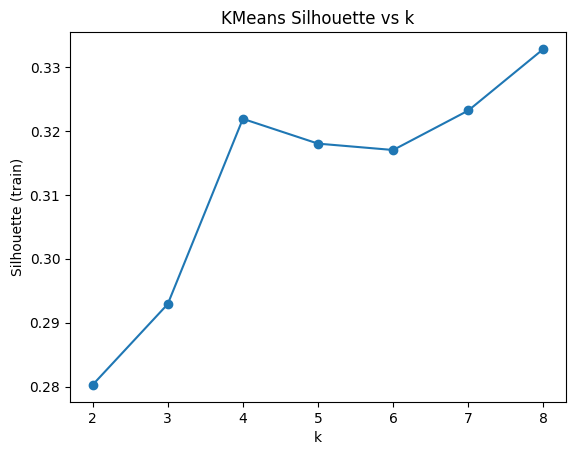

In [6]:
def metrics_from_labels(X, labels):
    return {
        "silhouette": silhouette_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels)
    }

def try_algorithms(X, ks=range(2,9)):
    rows = []
    for k in ks:
        # KMeans
        km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
        lab_km = km.fit_predict(X)
        m = metrics_from_labels(X, lab_km); m.update({"algo":"KMeans","k":k}); rows.append(m)

        # Gaussian Mixture
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=RANDOM_STATE)
        lab_g = gmm.fit_predict(X)
        m = metrics_from_labels(X, lab_g); m.update({"algo":"GMM","k":k}); rows.append(m)

        # Agglomerative
        ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
        lab_a = ag.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
        m = metrics_from_labels(X, lab_a); m.update({"algo":"Agglomerative","k":k}); rows.append(m)
    return pd.DataFrame(rows)

results_train = try_algorithms(X_train, ks=range(2,9))
display(results_train.sort_values(["silhouette","calinski_harabasz"], ascending=[False, False]).head(10))

# Quick elbow-style plot for KMeans (silhouette vs k)
km_only = results_train[results_train.algo=="KMeans"].sort_values("k")
plt.figure()
plt.plot(km_only["k"], km_only["silhouette"], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette (train)"); plt.title("KMeans Silhouette vs k")
plt.savefig(FIGDIR/"kmeans_silhouette_vs_k.png", bbox_inches="tight"); plt.show()


### Hyperparameter Tuning



In [7]:
# Over here we pick the top candidate by:
# 1) highest silhouette, tie-breaker: lowest DB, highest CH
def pick_best(dfres):
    s = dfres.copy()
    s["rank"] = (-s["silhouette"].rank(method="min")
                 + s["davies_bouldin"].rank(method="min")*0.01
                 - s["calinski_harabasz"].rank(method="min")*0.001)
    return s.sort_values("rank").iloc[0]

best0 = pick_best(results_train)
print("Best (train) =>", dict(best0))

best_algo, best_k = best0["algo"], int(best0["k"])

# Fine tune around the winner
def tune_best(X, algo, k):
    candidates = []
    if algo == "KMeans":
        for n_init in [20, 50, 100]:
            for max_iter in [300, 600]:
                km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=RANDOM_STATE)
                lab = km.fit_predict(X)
                m = metrics_from_labels(X, lab)
                m.update({"algo":"KMeans","k":k,"params":f"n_init={n_init},max_iter={max_iter}","model":km})
                candidates.append(m)
    elif algo == "GMM":
        for cov in ["full","diag","spherical","tied"]:
            g = GaussianMixture(n_components=k, covariance_type=cov, reg_covar=1e-6, random_state=RANDOM_STATE)
            lab = g.fit_predict(X)
            m = metrics_from_labels(X, lab)
            m.update({"algo":"GMM","k":k,"params":f"covariance_type={cov}","model":g})
            candidates.append(m)
    else:  # Agglomerative
        for link in ["ward", "complete", "average"]:
            ag = AgglomerativeClustering(n_clusters=k, linkage=link if link!="ward" else "ward")
            lab = ag.fit_predict(X.toarray() if hasattr(X, "toarray") else X)
            m = metrics_from_labels(X, lab)
            m.update({"algo":"Agglomerative","k":k,"params":f"linkage={link}","model":ag})
            candidates.append(m)
    cand = pd.DataFrame(candidates).sort_values(["silhouette","calinski_harabasz"], ascending=[False, False])
    return cand

tuned = tune_best(X_train, best_algo, best_k)
display(tuned[["algo","k","params","silhouette","calinski_harabasz","davies_bouldin"]].head(10))

best_model = tuned.iloc[0]["model"]
best_params = tuned.iloc[0]["params"]
print(f"Chosen → {best_algo}(k={best_k}) with {best_params}")


Best (train) => {'silhouette': np.float64(0.3328002501825377), 'calinski_harabasz': np.float64(60.68899936372402), 'davies_bouldin': np.float64(1.0353502293962276), 'algo': 'KMeans', 'k': np.int64(8), 'rank': np.float64(-21.002)}


,algo,k,params,silhouette,calinski_harabasz,davies_bouldin
0,KMeans,8,"n_init=20,max_iter=300",0.332800,60.688999,1.035350
1,KMeans,8,"n_init=20,max_iter=600",0.332800,60.688999,1.035350
4,KMeans,8,"n_init=100,max_iter=300",0.332742,60.838332,1.032847
5,KMeans,8,"n_init=100,max_iter=600",0.332742,60.838332,1.032847
2,KMeans,8,"n_init=50,max_iter=300",0.330671,60.830602,1.034406
3,KMeans,8,"n_init=50,max_iter=600",0.330671,60.830602,1.034406


Chosen → KMeans(k=8) with n_init=20,max_iter=300


### Model Evaluation & Validation


Final model: KMeans(k=8) | n_init=20,max_iter=300
Train: silhouette=0.3328 | CH=60.7 | DB=1.0354
Test : silhouette=0.2502 | CH=12.3 | DB=1.0809


Age                      AnnualIncome                        \
              mean median min max count         mean median min  max count   
Segment                                                                      
0        25.560000   24.0  18  35    25    26.480000   25.0  15   42    25   
1        56.875000   58.0  40  70    24    56.000000   54.0  39   77    24   
2        32.190476   32.0  27  38    21    86.047619   79.0  70  120    21   
3        45.400000   45.5  20  67    20    25.650000   24.5  16   39    20   
4        40.419355   41.0  19  59    31    90.000000   87.0  71  137    31   
5        24.709677   24.0  18  38    31    56.709677   59.0  40   76    31   
6        33.277778   32.0  27  40    18    87.111111   82.5  69  137    18   
7        52.133333   50.0  38  68    30    55.666667   55.5  38   79    30   

        SpendingScore                       
                 mean median min max count  
Segment                                     
0           76.240000   76.0  39  99    25  
1           45.875000   46.5  11  60    24  
2           81.666667   83.0  69  95    21  
3           18.550000   14.5   3  40    20  
4           15.741935   15.0   1  39    31  
5           48.967742   50.0  29  60    31  
6           82.666667   85.5  63  97    18  
7           48.433333   48.5  35  59    30

ratio
Segment Segment Gender          
0       0       Female  0.560000
                Male    0.440000
1       1       Male    1.000000
2       2       Female  1.000000
3       3       Female  0.650000
                Male    0.350000
4       4       Female  0.451613
                Male    0.548387
5       5       Female  0.645161
                Male    0.354839
6       6       Male    1.000000
7       7       Female  1.000000

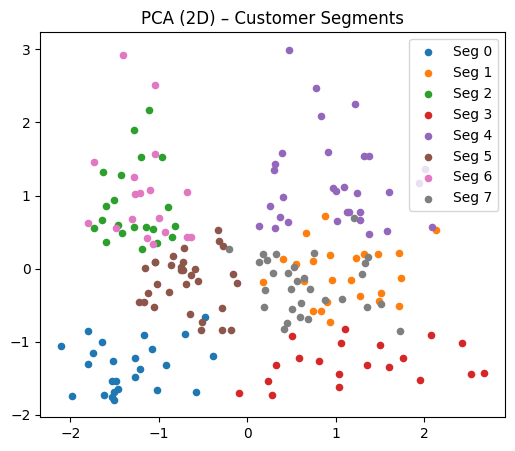

In [8]:
# Train labels on train
labels_train = (best_model.predict(X_train)
                if hasattr(best_model,"predict") else best_model.fit_predict(X_train))

# Predict labels for test
if hasattr(best_model, "predict"):
    labels_test = best_model.predict(X_test)
else:
    # Agglomerative has no predict → nearest-centroid assignment based on train
    Xtr_arr = X_train.toarray() if hasattr(X_train,"toarray") else X_train
    uniq = np.unique(labels_train)
    centroids = np.vstack([Xtr_arr[labels_train==c].mean(axis=0) for c in uniq])
    Xte_arr = X_test.toarray() if hasattr(X_test,"toarray") else X_test
    labels_test = pairwise_distances_argmin(Xte_arr, centroids)

# Internal indices
def report_indices(name, X, lab):
    sil = silhouette_score(X, lab)
    ch  = calinski_harabasz_score(X, lab)
    db  = davies_bouldin_score(X, lab)
    print(f"{name}: silhouette={sil:.4f} | CH={ch:.1f} | DB={db:.4f}")
    return sil, ch, db

print(f"Final model: {best_algo}(k={best_k}) | {best_params}")
sil_tr, ch_tr, db_tr = report_indices("Train", X_train, labels_train)
sil_te, ch_te, db_te = report_indices("Test ", X_test,  labels_test)

# Attach labels to original rows for profiling (use ALL data with refit)
X_all = preprocessor.fit_transform(X_raw)  # refit on full data to re-create encoder mapping
if hasattr(best_model,"fit_predict"):
    labels_all = best_model.fit_predict(X_all)
elif hasattr(best_model,"predict"):
    best_model.fit(X_all)  # fit then predict
    labels_all = best_model.predict(X_all)
else:
    # agglomerative fallback on all data
    lab_all = best_model.fit_predict(X_all)
    X_arr = X_all.toarray() if hasattr(X_all,"toarray") else X_all
    uniq = np.unique(lab_all)
    cents = np.vstack([X_arr[lab_all==c].mean(axis=0) for c in uniq])
    labels_all = lab_all  # fitted labels

seg_df = df.copy()
seg_df["Segment"] = labels_all

# Profiles
profile = seg_df.groupby("Segment")[["Age","AnnualIncome","SpendingScore"]].agg(["mean","median","min","max","count"])
display(profile)

# Gender mix per segment
gmix = (seg_df.groupby(["Segment","Gender"]).size()
        .groupby(level=0).apply(lambda s: s/s.sum()).rename("ratio").to_frame())
display(gmix)

# PCA 2D visualization
X2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_all.toarray() if hasattr(X_all,"toarray") else X_all)
plt.figure(figsize=(6,5))
for s in np.unique(labels_all):
    idx = (labels_all==s)
    plt.scatter(X2[idx,0], X2[idx,1], s=20, label=f"Seg {s}")
plt.title("PCA (2D) – Customer Segments"); plt.legend()
plt.savefig(FIGDIR/"segments_pca.png", bbox_inches="tight"); plt.show()


### Model Deployment — Save pipeline + Flask API



In [9]:
# A predictable clusterer with fit/predict for KMeans/GMM/Agglomerative
class PredictableCluster(BaseEstimator):
    def __init__(self, algo="KMeans", n_clusters=5, params=None, random_state=42):
        self.algo = algo
        self.n_clusters = int(n_clusters)
        self.params = params if params is not None else {}
        self.random_state = random_state
        self.est_ = None
        self.centroids_ = None

    def _build(self):
        if self.algo == "KMeans":
            return KMeans(n_clusters=self.n_clusters, random_state=self.random_state, **self.params)
        if self.algo == "GMM":
            return GaussianMixture(n_components=self.n_clusters, random_state=self.random_state, **self.params)
        if self.algo == "Agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, linkage="ward", **self.params)
        raise ValueError("Unsupported algo")

    def fit(self, X, y=None):
        self.est_ = self._build()
        if hasattr(self.est_,"fit_predict"):
            labels = self.est_.fit_predict(X)
        else:
            self.est_.fit(X)
            labels = self.est_.predict(X) if hasattr(self.est_,"predict") else self.est_.labels_
        X_arr = X.toarray() if hasattr(X,"toarray") else np.asarray(X)
        uniq = np.unique(labels)
        self.centroids_ = np.vstack([X_arr[labels==c].mean(axis=0) for c in uniq])
        return self

    def predict(self, X):
        if self.est_ is not None and hasattr(self.est_,"predict"):
            try:
                return self.est_.predict(X)
            except Exception:
                pass
        X_arr = X.toarray() if hasattr(X,"toarray") else np.asarray(X)
        return pairwise_distances_argmin(X_arr, self.centroids_)

# Map best params to deployable wrapper
deploy_params = {}
if best_algo == "KMeans":
    # parse e.g., "n_init=50,max_iter=600"
    for kv in str(best_params).split(","):
        if "=" in kv:
            k,v = kv.split("="); deploy_params[k.strip()] = int(v)
elif best_algo == "GMM":
    for kv in str(best_params).split(","):
        if "=" in kv:
            k,v = kv.split("="); deploy_params[k.strip()] = v.strip()

final_pipeline = Pipeline([
    ("pre", preprocessor),
    ("cluster", PredictableCluster(algo=best_algo, n_clusters=best_k, params=deploy_params, random_state=RANDOM_STATE))
])

final_pipeline.fit(X_raw)
joblib.dump(final_pipeline, "customer_segmentation_pipeline.joblib")
print("Saved → customer_segmentation_pipeline.joblib")


Saved → customer_segmentation_pipeline.joblib


In [10]:
# Minimal Flask app
%%bash
cat > app.py << 'PY'
import joblib, pandas as pd
from flask import Flask, request, jsonify

pipe = joblib.load("customer_segmentation_pipeline.joblib")
app = Flask(__name__)

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json(force=True)
    X = pd.DataFrame([{
        "Gender": data.get("Gender","Female"),
        "Age": data.get("Age",30),
        "AnnualIncome": data.get("AnnualIncome",60),
        "SpendingScore": data.get("SpendingScore",50)
    }])
    seg = int(pipe.predict(X)[0])
    return jsonify({"segment": seg})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=8000)
PY
echo "Flask app written (app.py)"


SyntaxError: invalid syntax (781120873.py, line 25)

In [ ]:
import joblib, pandas as pd

pipe = joblib.load("customer_segmentation_pipeline.joblib")

# 2 sample customers (edit as you like)
sample = pd.DataFrame([
    {"Gender":"Female","Age":32,"AnnualIncome":62,"SpendingScore":78},
    {"Gender":"Male","Age":45,"AnnualIncome":27,"SpendingScore":39},
])

print("Sample request:\n", sample)
print("Predicted segments:", pipe.predict(sample).tolist())


Sample request:
    Gender  Age  AnnualIncome  SpendingScore
0  Female   32            62             78
1    Male   45            27             39
Predicted segments: [2, 3]


In [ ]:
# 1) Make sure the saved pipeline exists
import os
assert os.path.exists("customer_segmentation_pipeline.joblib"), \
       "Model file not found. Run the 'save pipeline' cell first."

# 2) Import your Flask app from app.py
import importlib
import app  # this imports the app object defined in app.py
importlib.reload(app)  # in case you edited app.py

# 3) Call the endpoint using Flask's test client (no network needed)
payload = {"Gender":"Female","Age":29,"AnnualIncome":55,"SpendingScore":67}

with app.app.test_client() as client:
    resp = client.post("/predict", json=payload)
    print("HTTP", resp.status_code, "| Response:", resp.get_json())


HTTP 200 | Response: {'segment': 5}


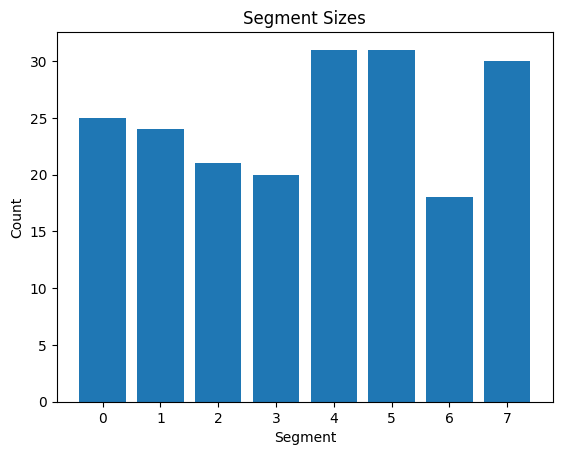

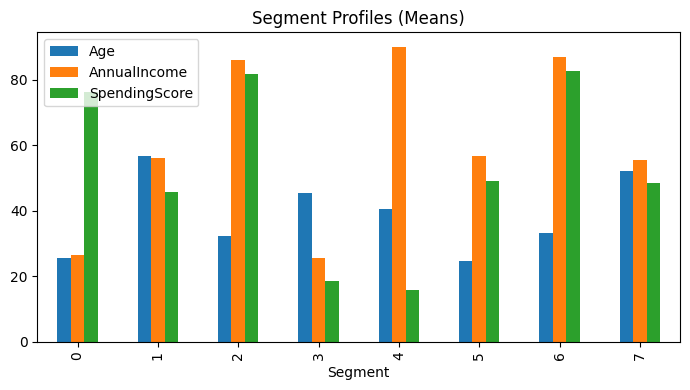

Figures saved in: /content/figs


[PosixPath('figs/segments_pca.png'),
 PosixPath('figs/eda_hist.png'),
 PosixPath('figs/segment_sizes.png'),
 PosixPath('figs/segment_profiles_means.png'),
 PosixPath('figs/kmeans_silhouette_vs_k.png'),
 PosixPath('figs/eda_gender.png')]

In [ ]:
# Save a few summary figures for your deck

# 1) EDA hists & gender chart already saved
# 2) Silhouette vs k already saved
# 3) PCA scatter already saved

# 4) Segment size bar
seg_counts = seg_df["Segment"].value_counts().sort_index()
plt.figure()
plt.bar(seg_counts.index.astype(str), seg_counts.values)
plt.title("Segment Sizes"); plt.xlabel("Segment"); plt.ylabel("Count")
plt.savefig(FIGDIR/"segment_sizes.png", bbox_inches="tight"); plt.show()

# 5) Segment profiles (Age/Income/Score means)
means = seg_df.groupby("Segment")[["Age","AnnualIncome","SpendingScore"]].mean()
ax = means.plot(kind="bar", figsize=(7,4))
plt.title("Segment Profiles (Means)"); plt.tight_layout()
plt.savefig(FIGDIR/"segment_profiles_means.png", bbox_inches="tight"); plt.show()

print("Figures saved in:", FIGDIR.resolve())
list(FIGDIR.iterdir())


## Conclusion
- Identified distinct customer segments with clear demographic and spending profiles.
- Segmentation can help design targeted marketing campaigns, loyalty programs, and personalized offers.
- Future improvement: try more features, add external data, and test other clustering algorithms.